In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [ ]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
train_X,test_X=train_X.reshape(60000,784),test_X.reshape(10000,784)

In [ ]:
train_X.shape,test_X.shape

((60000, 784), (10000, 784))

In [ ]:
data=torch.from_numpy(train_X).to(torch.float32)/255
data_test=torch.from_numpy(test_X).to(torch.float32)/255

data.dtype

torch.float32

In [ ]:
batch_size = 100
train_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim, input_dim=784, hidden_dim=128):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2*latent_dim)
            # Removed the ReLU here
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        #print(x)  # Now this should show non-zero values for log_var
        mu, log_var = x.chunk(2, dim=1)
       # print(log_var)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        eps = torch.randn_like(log_var)
        return mu + eps * torch.exp(0.5 * log_var)  # Modifying to use the standard deviation

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var


In [ ]:
def loss_function(x, x_hat, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction = 'sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx,x in enumerate(train_loader):
            x = x.view(batch_size, 784).to(device)

            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        # print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [ ]:
def latent_space_analyse(model):
    model.eval()
    losses = []
    reconstruced_images = []
    for batch_idx,x in enumerate(test_loader):
        x = x.view(batch_size, 784).to(device)
        x_hat, mean, log_var = model(x)
        reconstruced_images.extend(x_hat.detach().cpu().numpy())
    return reconstruced_images

def mean_squared_error(original, reconstructed):
  return np.mean((original - reconstructed) ** 2)

def sample_and_visualize(model, num_samples=5, latent_dim=10):
    model.eval()
    z = torch.randn(num_samples, latent_dim)
    z = z.to(next(model.parameters()).device)
    with torch.no_grad():
        samples = model.decode(z)

    samples = samples.view(num_samples, 28, 28).cpu()
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
    fig.suptitle(f'Latent Dimension: {latent_dim}')

    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.show()

def compute_latent_stats(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    total_mu = 0
    total_log_var = 0
    total_count = 0

    with torch.no_grad():  # Disable gradient computation
        for data in data_loader:
            data = data.to(device)
            mu, log_var = model.encode(data)
            total_mu += mu.sum(dim=0)
            total_log_var += log_var.sum(dim=0)
            total_count += data.size(0)

    # Compute the average of mu and log_var across all data
    avg_mu = total_mu / total_count
    avg_log_var = total_log_var / total_count

    avg_log_var_diag = torch.diag(torch.exp(avg_log_var))  # Using exp to convert log variance to variance

    return avg_mu, avg_log_var_diag


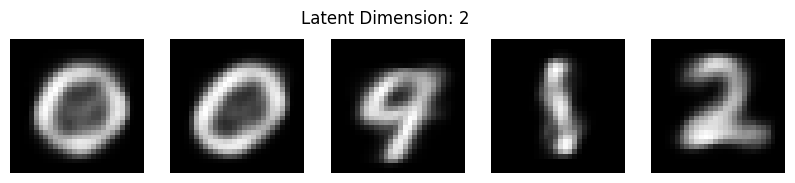

Average Mean: tensor([0.2367, 0.1267], device='cuda:0')
Average Variance:
tensor([[0.0089, 0.0000],
        [0.0000, 0.0066]], device='cuda:0')


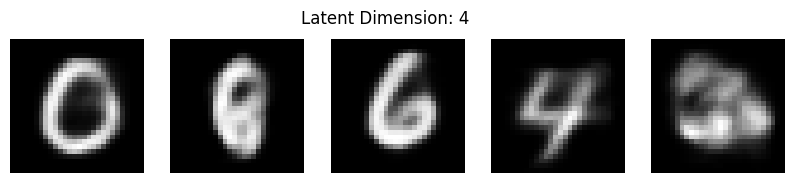

Average Mean: tensor([-0.1119,  0.0393, -0.1118, -0.1937], device='cuda:0')
Average Variance:
tensor([[0.0137, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0116, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0166, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0162]], device='cuda:0')


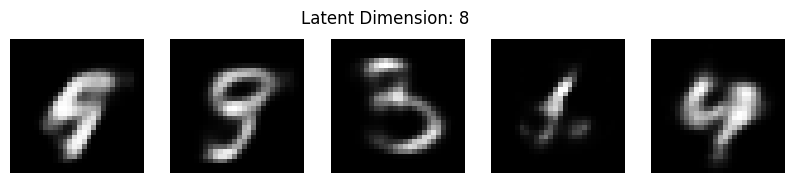

Average Mean: tensor([-0.0512, -0.0519, -0.1023, -0.0720, -0.1323, -0.0383,  0.0717,  0.0117],
       device='cuda:0')
Average Variance:
tensor([[0.0250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0285, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0283, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0423, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0284, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0220, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0259, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0195]],
       device='cuda:0')


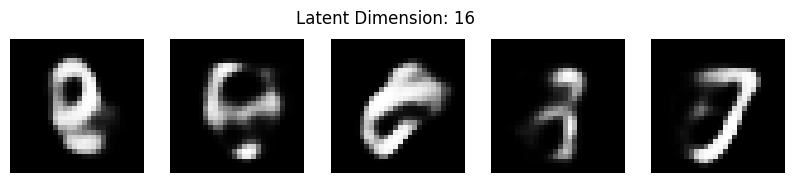

Average Mean: tensor([ 0.0553,  0.0546,  0.0284,  0.0363, -0.0267, -0.0358, -0.0387, -0.0456,
         0.0178,  0.0450,  0.1357,  0.0075, -0.0089,  0.0026, -0.1011,  0.0739],
       device='cuda:0')
Average Variance:
tensor([[0.0294, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0520, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0290, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0679, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1123, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

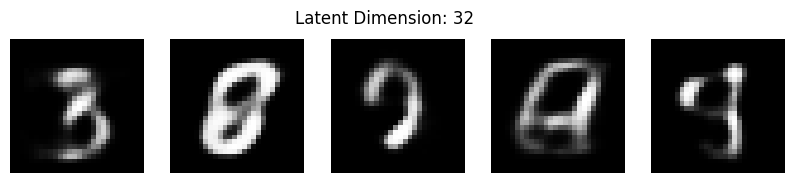

Average Mean: tensor([-0.0270,  0.0076, -0.0993, -0.0147,  0.1342,  0.0183,  0.0042, -0.0147,
        -0.0064,  0.0368,  0.0048,  0.0297, -0.0055, -0.0059,  0.0186,  0.0277,
         0.0179, -0.0567, -0.0379,  0.0250,  0.0919, -0.0462,  0.0322, -0.0010,
        -0.0224, -0.0507,  0.0360, -0.0461,  0.0134,  0.0293, -0.0064,  0.0040],
       device='cuda:0')
Average Variance:
tensor([[0.1969, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9670, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0651,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0403, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2493, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0532]],
       device='cuda:0')


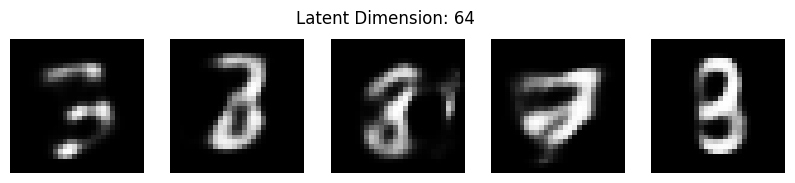

Average Mean: tensor([ 0.0303, -0.0115, -0.0132, -0.0061,  0.0033, -0.0021,  0.0271, -0.0104,
        -0.0166, -0.0074,  0.0231,  0.0079,  0.0011, -0.0413, -0.0125, -0.0015,
        -0.0374, -0.0347,  0.0009,  0.0289,  0.0267,  0.0507, -0.0251, -0.0191,
        -0.0049,  0.0176,  0.0220,  0.0112, -0.0205, -0.0130, -0.0162,  0.0001,
         0.0029,  0.0219,  0.0557, -0.0142,  0.0108, -0.0101,  0.0254, -0.0573,
         0.0119, -0.0159,  0.0039, -0.0090, -0.0277,  0.0710,  0.0148, -0.0087,
        -0.0013,  0.0219, -0.0020,  0.0029,  0.0205, -0.0315,  0.0002,  0.0168,
        -0.0037, -0.0047,  0.0025, -0.0116, -0.0209, -0.0034, -0.0116,  0.0348],
       device='cuda:0')
Average Variance:
tensor([[0.1540, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9923, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0409,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.9891, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  

In [ ]:
np.random.seed(42)
latent_dims = [2, 4, 8, 16, 32, 64]
indices = np.random.choice(range(10000), 5, replace=False)


for latent_dim in latent_dims:
    model = VAE(latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train(model, optimizer, 10, device)
    sample_and_visualize(model,5,latent_dim)
    avg_mu,avg_var=compute_latent_stats(model,train_loader,device)
    print(f"Average Mean: {avg_mu}")
    print(f"Average Variance:")
    print(avg_var)


    plt.show()